In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
cd /content/drive/MyDrive/ADA_Proj

/content/drive/MyDrive/ADA_Proj


# Introduction

By the end of this milestone we expect to be able to:

  1. Load and filter Quotebank Dataset to take only bitcoin-related quotes
  2. Do some basic analysis and sanity checks to see if data is consistent
  3. Do further preprocessing to take the best of our limited data
  4. Leverage sentiment analysis from machine learning models to get some insight about market reactions to Bitcoin.

## Context

In the last five years, Bitcoin was by far the most volatile largely traded asset. Given its decentralized nature, multiple factors can manipulate its price direction. We would like to shed light on one of those factors: News. On one side, retail investors stem their entry and exit strategies (when to buy and when to sell) from the feeling conveyed by the subjective speeches of notorious public investors, which may cause drastic fluctuations in the bitcoin's price and trading volume. On the other side, news and social media are known to be very reactive to the cryptocurrency market fluctuations. A fear and greed index reproduces this aspect based on crowdsourcing feelings from social media, Google trends and surveys analysis. <br>
Using the Quotebank dataset, we would like to investigate the correlation and the potential causality between the news and Bitcoin’s historical data.

## Data

The data consists of Quotebank quotes which is a dataset of 178 million quotes which we'll take a subset of that corresponds to our subject.<br>
For each quote, we have these information:

    1. QuoteID : Primary key of the quotation (format: "YYYY-MM-DD-{increasing int:06d}")
    2. quotation : Text of the longest encountered original form of the quotation
    3. Speaker : Selected most likely speaker. This matches the the first speaker entry in `probas`
    4. qids : Wikidata IDs of all aliases that match the selected speaker
    5. date : the occurence date of the quote in the website/support
    6. numOccurences : Number of time this quotation occurs in the articles
    7. probas : Array representing the probabilities of each speaker having uttered the quotation
    8. urls : List of links to the original articles containing the quotation 
    9. phase :  Corresponding phase of the data in which the quotation first occurred (A-E)

## Table of content: <a class="anchor" id="top"></a>
* [Part 1: Data Loading](#part1)
* [Part 2: Data Analysis](#part2)
    * [Task 1: Basic analysis](#part2.1)
    * [Task 2: Occupation matching](#part2.2)
    * [Task 3: Sentiment Analysis](#part2.3)
    * [Task 4: Causality/Correlation](#part2.4)
    * [Task 5: Occupation Bias](#part2.5)

PS: Tasks 2-5 will be done in separate notebooks for clarity and version control purposes.

In [ ]:
# To write plotly plots on the drive

!pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
import pandas as pd
import numpy as np
import bz2
import json
import csv

import seaborn as sns
import string
from tqdm import tqdm
from datetime import *

import ast 
from collections import defaultdict, Counter

!pip3 install transformers
from transformers import pipeline

import ast 
from collections import defaultdict, Counter
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
#from IPython.display import Image
from PIL import Image

# Part 1: Data Loading <a class="anchor" id="part1"></a>

We load data containing "bitcoin" and "Bitcoin" from Quotebank dataset during the period 2015-2020 and register it for each year, then concatenate all the dataframes into one dataframe that we will preprocess and process later on the analysis notebook.
<br> This is a one-time operation and all algorithms will then be applied on the already available data.

In [ ]:
for year in range(2015,2021): 
  path_to_file = f'Data/Quotebank/quotes-{year}.json.bz2' 
  bitcoin_year = []

  with bz2.open(path_to_file, 'rb') as s_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              if 'Bitcoin' in instance['quotation'] or 'bitcoin' in instance['quotation']: # extracting list of links            
                bitcoin_year.append(instance)
  df_year = pd.DataFrame(bitcoin_year)
  df_year.to_csv(f'./Data/bitcoin_quotes_{year}.csv')

In [ ]:
df_2015 = pd.read_csv('./Data/bitcoin_quotes_2015.csv')
df_2016 = pd.read_csv('./Data/bitcoin_quotes_2016.csv')
df_2017 = pd.read_csv('./Data/bitcoin_quotes_2017.csv')
df_2018 = pd.read_csv('./Data/bitcoin_quotes_2018.csv')
df_2019 = pd.read_csv('./Data/bitcoin_quotes_2019.csv')
df_2020 = pd.read_csv('./Data/bitcoin_quotes_2020.csv')
df_bitcoin = pd.concat([df_2015, df_2016, df_2017, df_2018, df_2019, df_2020],ignore_index=True).iloc[:, 1:]
df_bitcoin.to_csv('Data/bitcoin_data.csv', index=False)

# Part 2: Data Analysis <a class="anchor" id="part2"></a>

## Task 1 : Basic analysis and sanity check <a class="anchor" id="part2.1"></a>

This section will mainly show how are our data points spread over time to see how can conclusions be drawn.

### Basic statstics

In [6]:
df_bitcoin = pd.read_csv('./M3/Data/bitcoin_data.csv')
df_bitcoin.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-10-04-032770,Litecoin Shows There Is a Simple Fix for Spam ...,Charlie Lee,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']",2015-10-04 18:48:44,1,"[['Charlie Lee', '0.9254'], ['None', '0.0746']]",['http://cointelegraph.com/news/115374/the-ong...,E
1,2015-09-15-114302,We believe that you deserve to reap the benefi...,Vishal Gupta,['Q57623555'],2015-09-15 20:32:32,1,"[['Vishal Gupta', '0.5501'], ['None', '0.2781'...",['http://benzinga.com/news/15/09/5835310/bitco...,E
2,2015-02-06-003563,AmEx needs to get into Bitcoin or one of the o...,Porter Bibb,['Q7231593'],2015-02-06 21:39:00,2,"[['Porter Bibb', '0.8712'], ['None', '0.1288']]",['http://us.rd.yahoo.com/finance/external/inve...,E
3,2015-06-22-017667,If each bitcoin has a history and people know ...,Greg Maxwell,['Q46997142'],2015-06-22 14:45:56,1,"[['Greg Maxwell', '0.966'], ['None', '0.034']]",['http://www.newsbtc.com/2015/06/22/how-blocks...,E
4,2015-10-07-012201,Bitcoin in its current incarnation is slow in ...,Ann Cairns,['Q28870363'],2015-10-07 17:02:57,1,"[['Ann Cairns', '0.8585'], ['None', '0.1415']]",['http://cointelegraph.com/news/115390/masterc...,E


We start by adding time columns which will be useful to split data over time for further analysis and pattern recognition.

In [7]:
df_bitcoin['month'] = pd.to_datetime(df_bitcoin['date']).dt.to_period('M')
df_bitcoin['day'] = pd.to_datetime(df_bitcoin['date']).dt.to_period('D')
df_bitcoin['year'] = pd.to_datetime(df_bitcoin['date']).dt.to_period('Y')
df_bitcoin['month_nb'] = pd.to_datetime(df_bitcoin['date']).dt.month

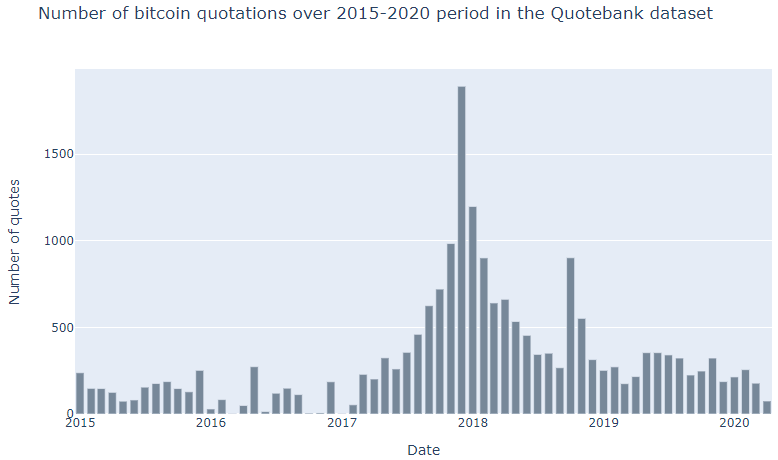

In [29]:
df_time = df_bitcoin.groupby('month')['quotation'].count()
df_time = pd.DataFrame(df_time).rename(columns={'quotation':'count'}).reset_index()
df_time['month'] = df_time['month'].apply(lambda x : x.to_timestamp())
df_time['month'] = pd.to_datetime(df_time['month'])
fig = go.Figure(data=[go.Bar(x=df_time['month'],y=df_time['count'], marker_color='lightslategrey')])
fig.update_layout(
  title="Number of bitcoin quotations over 2015-2020 period in the Quotebank dataset",
  xaxis_title="Date",
  yaxis_title="Number of quotes",
  )
fig.write_image("./M3/Images/num_quotes.png")
Image.open("./M3/Images/num_quotes.png")

### Basic statstics about speakers

When we talk about a subject as serious as bitcoin and crypto in general, the identity of the speaker is as important as the quote itself, so it's only natural to see how is data distributed over speakers over time. 
In this subsection we first analyse the amount of data to see who are the most important and potentially influential speakers. Later on, we will leverage this information to analyse the behaviour and the feeling of these speakers independetly to make the best out of it.

In [30]:
def split_speakers(proba):
	'''
	Extract the speakers from the probas array of the dataframe
	'''
	splitted = proba.split('\'')
	speakers =[]
	for i in range(len(splitted)//4):
		speakers.append(splitted[1+4*i])
  
	return speakers

In [31]:
speakers = df_bitcoin['probas'].apply(lambda x: split_speakers(x))

# Take only the most probable speaker of each quote
most_likely_speakers = speakers.apply(lambda x: x[0])
counts_most_likely = most_likely_speakers.value_counts()

# A new column of the most likely speaker so that we can groupby them if necessary
df_bitcoin['most_likely_speaker'] = most_likely_speakers

In [32]:
counts_most_likely[1:10]

Tom Lee         303
Jamie Dimon     189
Roger Ver       184
Tim Draper      161
Craig Wright    157
Brian Kelly     150
Charlie Lee     149
Bobby Lee       148
Jack Dorsey     145
Name: probas, dtype: int64

Distribution of quotations about bitcoin over most influential speakers during the 2015-2020 period.

In [33]:
def count_by_speaker(speaker, df):
  '''
  Counts the number of quotations of the speaker
  '''
  quotations_of_speaker = df[df['most_likely_speaker']==speaker][['most_likely_speaker', 'month']]
  return quotations_of_speaker.groupby('month')['most_likely_speaker'].count().reset_index(name='counts')

In [34]:
def plot_count_speaker(speakers, df_bitcoin):
	'''
	Plots the number of quotationss of each spaeker of spaekers over time
	'''
	fig = go.Figure()
	for speaker in speakers:
		df = pd.DataFrame(count_by_speaker(speaker, df_bitcoin))
		df['month'] = pd.to_datetime(df['month'].apply(lambda x: x.to_timestamp()))
		fig.add_trace(go.Scatter(x=df['month'], y=df['counts'], name=speaker))
	fig.update_layout(
		title="Number of quotations by speaker over the years",
		xaxis_title="Date",
		yaxis_title="Number of quotes",
		)
	return fig

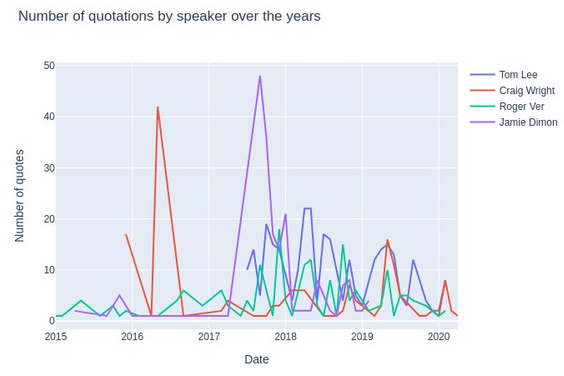

In [38]:
fig = plot_count_speaker(['Tom Lee', 'Craig Wright', 'Roger Ver', 'Jamie Dimon'], df_bitcoin)
fig.write_image("./M3/Images/quotations_by_speaker.png")
Image.open("./M3/Images/quotations_by_speaker.png")

Distribution of the number of quotes by speaker among all speakers

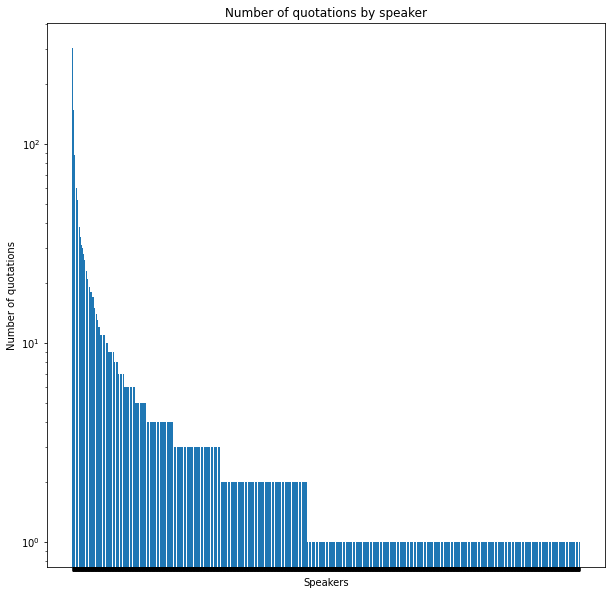

In [37]:
fig = plt.figure(figsize=(10,10))
plt.yscale('log')
plt.xlabel('Speakers')
plt.ylabel('Number of quotations')
plt.title('Number of quotations by speaker')
plt.bar(counts_most_likely.index[1:], counts_most_likely.values[1:])
plt.xticks(counts_most_likely.index[1:], "")

We expect the data to be too much noisy if we take each and every speaker, though to make our analysis more robust, we'll keep only speakers with at least 4 quotes to remove enough but not too much data points.

In [ ]:
selected_speakers = [counts_most_likely.index[i] for i in range(len(counts_most_likely)) if counts_most_likely.values[i]>=4]
selected_speakers.remove('None')
f'The percentage of speakers with at least 4 quotes is {100*len(selected_speakers)/len(counts_most_likely)}% of the total number of speakers'

'The percentage of speakers with at least 4 quotes is 19.98824221046443% of the total number of speakers'

In [ ]:
selection_arr =  df_bitcoin['speaker'].apply(lambda x: x in selected_speakers)
df_selected = df_bitcoin[selection_arr]
f'Thus we will keep {len(df_selected)} quotes for the analysis purpose.'

'Thus we will keep 9895 quotes for the analysis purpose.'

### Data Preprocessing

This section is about preprocessing data, in particular textual data (quotations). In order to make the best out of the sentiment analysis algorithm, we wanted to normalize data by lemmatizing it. We didn't apply other modifications as lowering, removing stopewords ... because Bert algorithm takes these into account to determine the sentiment.

In [ ]:
def remove_punctuation(s):
	'''
	Removes the punction from s
	'''
	return s.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

def lemmatize_text(s):
	'''
	Lemmatizes all the word of the string s
	'''
	lm = WordNetLemmatizer()
	wk = nltk.tokenize.WhitespaceTokenizer()
	return " ".join([lm.lemmatize(w) for w in wk.tokenize(s)])

def process(df_bitcoin):
	'''
	Processing the dataframe quotations
	'''
	df = df_bitcoin.copy()
	nltk.download('wordnet')
	df['quotation'] = remove_punctuation(df['quotation'])
	df['quotation'] = df['quotation'].apply(lambda s: lemmatize_text(s))
	return df

In [ ]:
df_lemmatized = process(df_selected)
df_lemmatized.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,month,day,year,month_nb,most_likely_speaker
0,2015-10-04-032770,Litecoin Shows There Is a Simple Fix for Spam ...,Charlie Lee,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']",2015-10-04 18:48:44,1,"[['Charlie Lee', '0.9254'], ['None', '0.0746']]",['http://cointelegraph.com/news/115374/the-ong...,E,2015-10,2015-10-04,2015,10,Charlie Lee
1,2015-09-15-114302,We believe that you deserve to reap the benefi...,Vishal Gupta,['Q57623555'],2015-09-15 20:32:32,1,"[['Vishal Gupta', '0.5501'], ['None', '0.2781'...",['http://benzinga.com/news/15/09/5835310/bitco...,E,2015-09,2015-09-15,2015,9,Vishal Gupta
3,2015-06-22-017667,If each bitcoin ha a history and people know h...,Greg Maxwell,['Q46997142'],2015-06-22 14:45:56,1,"[['Greg Maxwell', '0.966'], ['None', '0.034']]",['http://www.newsbtc.com/2015/06/22/how-blocks...,E,2015-06,2015-06-22,2015,6,Greg Maxwell
4,2015-10-07-012201,Bitcoin in it current incarnation is slow in t...,Ann Cairns,['Q28870363'],2015-10-07 17:02:57,1,"[['Ann Cairns', '0.8585'], ['None', '0.1415']]",['http://cointelegraph.com/news/115390/masterc...,E,2015-10,2015-10-07,2015,10,Ann Cairns
5,2015-04-05-046662,With the election in FebruaryMarch it became c...,Olivier Janssens,['Q58691424'],2015-04-05 10:17:56,2,"[['Olivier Janssens', '0.7651'], ['None', '0.2...",['http://www.coinspeaker.com/2015/04/05/olivie...,E,2015-04,2015-04-05,2015,4,Olivier Janssens


### A first insight into sentiment analysis

Bert algorithm is one of our main focuses in this project, it will allow us to determine if there exists some pattern linking  some important people's opinion about bitcoin to the volume/price eventual changes, as well as bear and bullish markets occurences.
<br> Hence, we start by apllying the trained Bert model which compares two sentences to our quotations: to test people sentiment about bitcoin, we see how each quotation is "near" or "far" from the sentences "The sentiment about bitcoin is positive" and "The sentiment about bitcoin is negative" which tells us if the sentiment is indeed positive or negative (based on a score).

In [ ]:
# Imports we will use for Bert model for sentiment analysis

try:
  from transformers import AutoModelForSequenceClassification, AutoTokenizer,AutoModelForTokenClassification
except:
  !pip install transformers
  from transformers import AutoModelForSequenceClassification, AutoTokenizer,AutoModelForTokenClassification

import torch
from torch.utils.data import IterableDataset, DataLoader

In [ ]:
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli',output_attentions=True).cuda()
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

In [ ]:
statements = df_lemmatized['quotation']

with torch.no_grad():
  positives = []
  negatives = []

  for statement in tqdm(statements):
      for sentiment in ['positive','negative']:
        hypothesis = 'The sentiment about bitcoin is {}.'.format(sentiment)
        x = tokenizer.encode(statement, hypothesis,return_tensors='pt',truncation_strategy='only_first')
        out=nli_model(x.cuda())
        logits = out[0]
        entail_contradiction_logits = logits[:,[0,2]]
        probs = entail_contradiction_logits.softmax(dim=1)
        prob_label_is_true = probs[:,1]
        if sentiment == 'positive':
          positives.append(prob_label_is_true.item())
        else:
          negatives.append(prob_label_is_true.item())

  0%|          | 0/9895 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2263: FutureWarning:

The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).

100%|██████████| 9895/9895 [20:54<00:00,  7.89it/s]


Add the columns of sentiment score to the dataframe.

In [ ]:
df_lemmatized['positive_score_btc'] = positives
df_lemmatized['negative_score_btc'] = negatives

In [ ]:
df_lemmatized.to_csv('./M3/Data/score_btc.csv', index=False)

### Visualization and comparison with greed/fear index

This section treats about a metric that will very likely be our main sanity check index as we took from an online dataset. It gives who much are people greedy or fearful concerning bitcoin at a certain point of time, which is obvisouly related to our sentiment analysis problem over quotes.

In [39]:
df_lemmatized = pd.read_csv('./M3/Data/score_btc.csv')
df_lemmatized.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,month,day,year,month_nb,most_likely_speaker,positive_score_btc,negative_score_btc
0,2015-10-04-032770,Litecoin Shows There Is a Simple Fix for Spam ...,Charlie Lee,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']",2015-10-04 18:48:44,1,"[['Charlie Lee', '0.9254'], ['None', '0.0746']]",['http://cointelegraph.com/news/115374/the-ong...,E,2015-10,2015-10-04,2015,10,Charlie Lee,0.052878,0.104096
1,2015-09-15-114302,We believe that you deserve to reap the benefi...,Vishal Gupta,['Q57623555'],2015-09-15 20:32:32,1,"[['Vishal Gupta', '0.5501'], ['None', '0.2781'...",['http://benzinga.com/news/15/09/5835310/bitco...,E,2015-09,2015-09-15,2015,9,Vishal Gupta,0.303506,0.000175
2,2015-02-06-003563,AmEx need to get into Bitcoin or one of the ot...,Porter Bibb,['Q7231593'],2015-02-06 21:39:00,2,"[['Porter Bibb', '0.8712'], ['None', '0.1288']]",['http://us.rd.yahoo.com/finance/external/inve...,E,2015-02,2015-02-06,2015,2,Porter Bibb,0.361056,0.015906
3,2015-06-22-017667,If each bitcoin ha a history and people know h...,Greg Maxwell,['Q46997142'],2015-06-22 14:45:56,1,"[['Greg Maxwell', '0.966'], ['None', '0.034']]",['http://www.newsbtc.com/2015/06/22/how-blocks...,E,2015-06,2015-06-22,2015,6,Greg Maxwell,0.006091,0.211665
4,2015-10-07-012201,Bitcoin in it current incarnation is slow in t...,Ann Cairns,['Q28870363'],2015-10-07 17:02:57,1,"[['Ann Cairns', '0.8585'], ['None', '0.1415']]",['http://cointelegraph.com/news/115390/masterc...,E,2015-10,2015-10-07,2015,10,Ann Cairns,0.008056,0.947546


We first visualize positive and negative scores of the sentiment model application.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



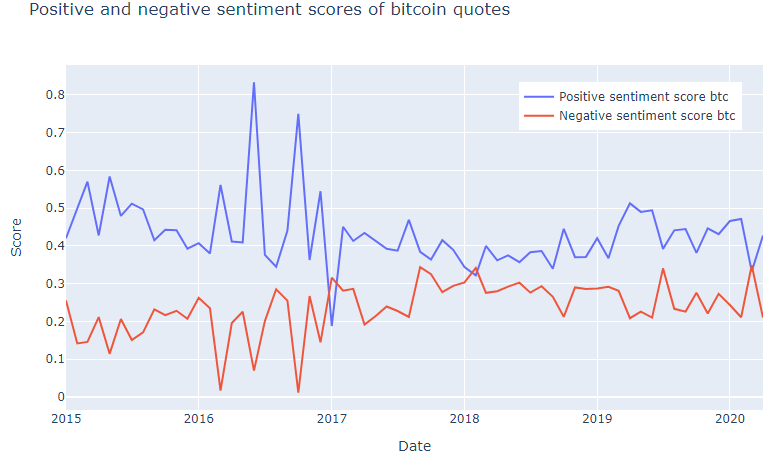

In [40]:
pos_neg_comp = df_lemmatized.groupby('month')['positive_score_btc','negative_score_btc'].mean()
fig = go.Figure([go.Scatter(x=pos_neg_comp.index, y=pos_neg_comp['positive_score_btc'].values, name='Positive sentiment score btc')])
fig.add_trace(go.Scatter(x=pos_neg_comp.index, y=pos_neg_comp['negative_score_btc'].values, name='Negative sentiment score btc'))
fig.update_layout(
  title="Positive and negative sentiment scores of bitcoin quotes",
  xaxis_title="Date",
  yaxis_title="Score",
  )
fig.update_layout(legend=dict(yanchor="top", y=0.95, xanchor="left", x=0.65))
fig.write_image("./M3/Images/sentiment.png")
Image.open("./M3/Images (1)/sentiment.png")

Then, we visualize the greed index over time

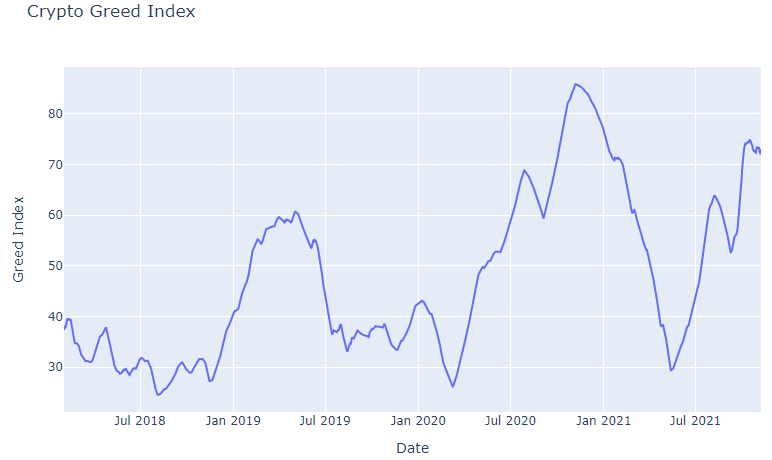

In [43]:
# read file
with open('./M3/Data/fear_greed_index.json', 'r') as myfile:
    data=myfile.read()
# parse file
obj = json.loads(data)
df = pd.json_normalize(obj['data'])
df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int), unit='s')
# Order the values following the y axis
df['value'] = df['value'].apply(pd.to_numeric).ewm(span = 100).mean()
# Plot
greed_idx_data = go.Scatter(x=df.timestamp, y=df.value)
layout = go.Layout(title='Crypto Greed Index', xaxis=dict(title='Date'), yaxis=dict(title='Greed Index'))
fig = go.Figure(
    data=[greed_idx_data],
    layout=layout)
fig.write_image("./M3/Images/greed_index.png")
Image.open("./M3/Images/greed_index.png")

Now, if we take the common period of the Quotebank dataset and greed/fear index dataset, say between February 2018 and April 2020, normalize them and put them in one plot, it gives the figure below.

In [45]:
def normalize(column):
	'''
	Normalizes the data of the column
	'''
	min_ = column.min()
	max_min = column.max() - column.min()
	return (column-min_)/max_min
  

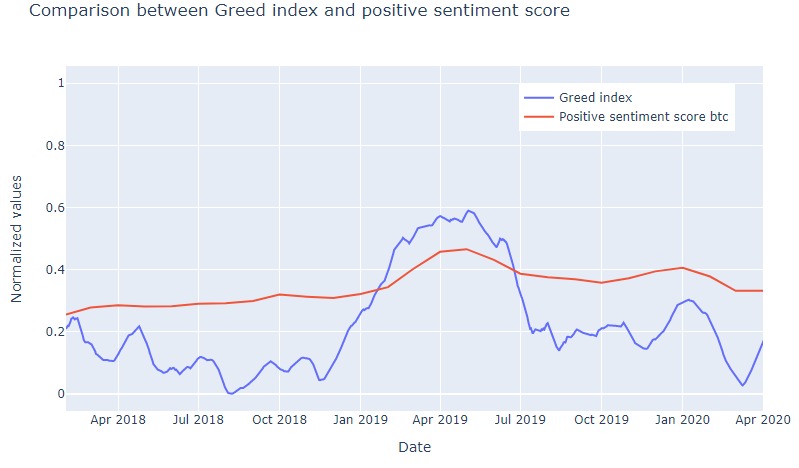

In [47]:
greed_idx_data = go.Scatter(x=df.timestamp, y=normalize(df.value), name='Greed index')
layout = go.Layout(title='Comparison between greed index and the positive score of quotations', xaxis=dict(title='Date'))
fig = go.Figure(
    data=[greed_idx_data],
    layout=layout)
smoothed_pos_scores = gaussian_filter1d(normalize(pos_neg_comp['positive_score_btc'].values), sigma=1)
fig.add_trace(go.Scatter(x=pos_neg_comp.index, y=smoothed_pos_scores, name='Positive sentiment score btc'))
fig.update_xaxes(range=[datetime(2018,2,1), datetime(2020,4,1)])
fig.update_layout(
  title="Comparison between Greed index and positive sentiment score",
  xaxis_title="Date",
  yaxis_title="Normalized values",
  )
fig.update_layout(legend=dict(yanchor="top", y=0.95, xanchor="left", x=0.65))
fig.write_image("./M3/Images/sentiment_vs_greed.png")
Image.open("./M3/Images/sentiment_vs_greed.png")

As we can see above, when focusing on the common period, standardizing the values and smoothing the functions to avoid too much noise, we see that the variations are analoguous, which means that our dataset is a quite interesting data too look at to see how the bitcoin and volume price may evolve.

### BTC Historical Data

In this section we look for possible patterns between BTC price and the number of quotations. We will explore this information in more depth later on.

In [48]:
bitcoin_price = pd.read_csv('./M3/Data/BTCUSD_day.csv')
bitcoin_price['Date'] = pd.to_datetime(bitcoin_price['Date']).dt.to_period('D')
bitcoin_price

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
0,2020-04-10,BTCUSD,7315.25,7315.25,7315.25,7315.25,0.00,0.00
1,2020-04-09,BTCUSD,7369.60,7378.85,7115.04,7315.25,2237.13,16310014.53
2,2020-04-08,BTCUSD,7201.81,7432.23,7152.80,7369.60,2483.60,18138080.27
3,2020-04-07,BTCUSD,7336.96,7468.42,7078.00,7201.81,2333.34,17047120.32
4,2020-04-06,BTCUSD,6775.21,7369.76,6771.01,7336.96,3727.47,26533750.17
...,...,...,...,...,...,...,...,...
1642,2015-10-12,BTCUSD,249.50,249.50,247.60,247.60,38.28,9493.89
1643,2015-10-11,BTCUSD,246.30,249.50,246.30,249.50,12.22,3021.12
1644,2015-10-10,BTCUSD,245.39,246.30,244.60,246.30,12.17,2984.44
1645,2015-10-09,BTCUSD,243.95,249.97,243.60,245.39,30.99,7651.63


In [49]:
bitcoin_price['date'] = bitcoin_price['Date'].apply(lambda x: x.to_timestamp())
bitcoin_price['month'] = pd.to_datetime(bitcoin_price['date']).dt.to_period('M')
price_month = bitcoin_price.groupby('month')['High'].mean()
price_month = pd.DataFrame(price_month).reset_index()
price_month['month'] = price_month['month'].apply(lambda x : x.to_timestamp())
price_month['month'] = pd.to_datetime(price_month['month'])
num_quotes = df_time[df_time['month']>=price_month['month'][0]]

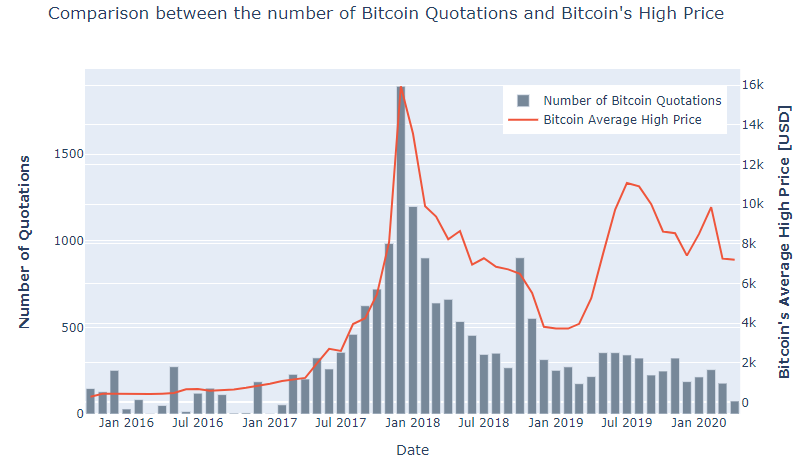

In [51]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Bar(x=num_quotes['month'],y=num_quotes['count'], marker_color='lightslategrey', name="Number of Bitcoin Quotations"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=price_month['month'],y=price_month['High'], name= "Bitcoin Average High Price"),
    secondary_y=True,)
fig.update_layout(
    title_text="Comparison between the number of Bitcoin Quotations and Bitcoin's High Price ")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Number of Quotations</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Bitcoin's Average High Price [USD]</b>", secondary_y=True)
fig.update_layout(legend=dict(yanchor="top", y=0.95, xanchor="left", x=0.6))
fig.write_image("./M3/Images/num_quotes_vs_btc_price.png")
Image.open("./M3/Images/num_quotes_vs_btc_price.png")

### How does most important speakers' sentiment change over time ?

In this subsection, we check how does some speakers' sentiment change over time (years, months ...)

First, by year

In [53]:
few_speakers = counts_most_likely.index[1:10]
df_by_speaker_year = df_lemmatized.groupby(['speaker', 'year'])['positive_score_btc', 'negative_score_btc'].mean().reset_index()
df_by_speaker_year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,speaker,year,positive_score_btc,negative_score_btc
0,50 Cent,2018,0.198582,0.507574
1,50 cent,2018,0.125140,0.005181
2,A. Ortiz,2019,0.006155,0.000257
3,Aaron Brown,2017,0.785697,0.037142
4,Aaron Brown,2018,0.326250,0.015554
...,...,...,...,...
4592,bram cohen,2017,0.000526,0.277463
4593,de Kok,2016,0.986530,0.000053
4594,de Voogd,2018,0.247240,0.721079
4595,fund manager,2019,0.000787,0.366526


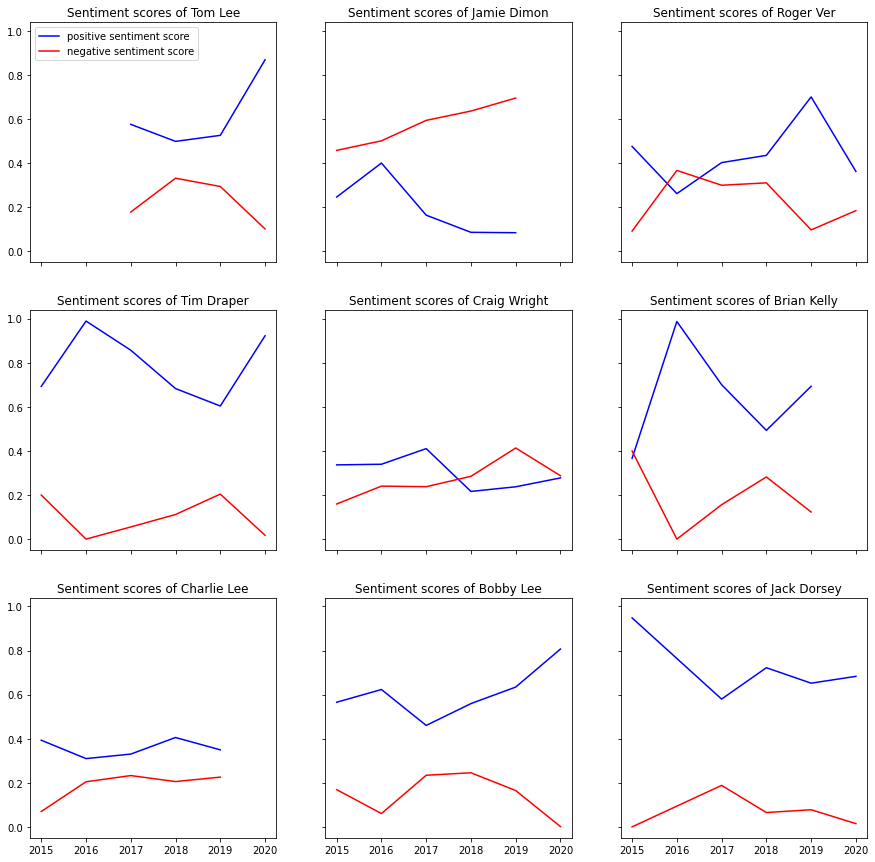

In [54]:
width, height = 3, 3
fig, ax = plt.subplots(width, height, figsize=(15,15), sharex=True, sharey=True)
ax = ax.ravel()
for i, speaker in enumerate(few_speakers):
  x = df_by_speaker_year[df_by_speaker_year['speaker']==speaker]['year']
  y_pos = df_by_speaker_year[df_by_speaker_year['speaker']==speaker]['positive_score_btc']
  y_neg = df_by_speaker_year[df_by_speaker_year['speaker']==speaker]['negative_score_btc']
  ax[i].plot(x, y_pos, color='b', label='positive sentiment score')
  ax[i].plot(x, y_neg, color='r', label='negative sentiment score')
  ax[i].set_title(f'Sentiment scores of {speaker}')
ax[0].legend()

Then, by month

In [55]:
df_by_speaker_month = df_lemmatized.groupby(['speaker', 'month'])['positive_score_btc', 'negative_score_btc'].mean().reset_index()
df_by_speaker_month['month'] = pd.to_datetime(df_by_speaker_month['month'])
df_by_speaker_month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,speaker,month,positive_score_btc,negative_score_btc
0,50 Cent,2018-01-01,0.019574,0.512164
1,50 Cent,2018-02-01,0.253662,0.506161
2,50 cent,2018-01-01,0.125140,0.005181
3,A. Ortiz,2019-02-01,0.006155,0.000257
4,Aaron Brown,2017-12-01,0.785697,0.037142
...,...,...,...,...
6744,bram cohen,2017-04-01,0.000526,0.277463
6745,de Kok,2016-06-01,0.986530,0.000053
6746,de Voogd,2018-10-01,0.247240,0.721079
6747,fund manager,2019-11-01,0.000787,0.366526


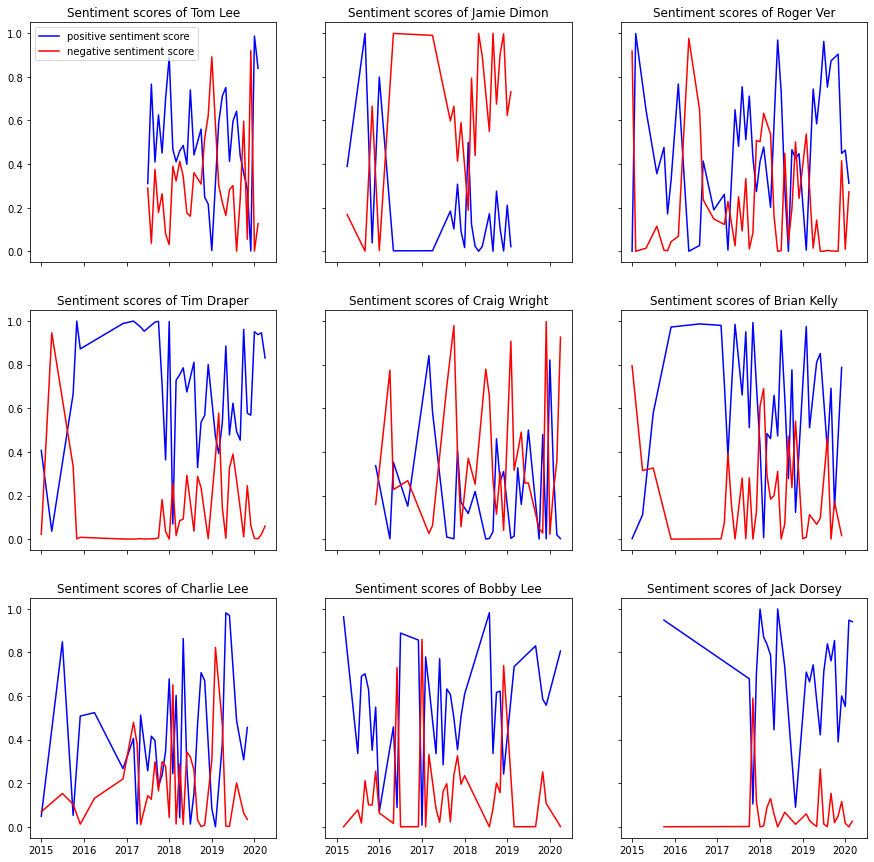

In [56]:
width, height = 3, 3
fig, ax = plt.subplots(width, height, figsize=(15,15), sharex=True, sharey=True)
ax = ax.ravel()
for i, speaker in enumerate(few_speakers):
  x = df_by_speaker_month[df_by_speaker_month['speaker']==speaker]['month']
  y_pos = df_by_speaker_month[df_by_speaker_month['speaker']==speaker]['positive_score_btc']
  y_neg = df_by_speaker_month[df_by_speaker_month['speaker']==speaker]['negative_score_btc']
  ax[i].plot(x, y_pos, color='b', label='positive sentiment score')
  ax[i].plot(x, y_neg, color='r', label='negative sentiment score')
  ax[i].set_title(f'Sentiment scores of {speaker}')
ax[0].legend()

As we can see, by month, the sentiment is way too noisy, so let's try by periods of 4 months

In [57]:
def appropriate_interval(date, daterange):
  for i in range(len(daterange)-1):
    if date>=daterange[i] and date<=daterange[i+1]:
      return i

In [58]:
daterange = pd.date_range('2014-12-12','2021-12-12' , freq='4M').tolist()
date_indices = list(range(len(daterange)))
df_lemmatized['date'] = pd.to_datetime(df_lemmatized['date'])
df_timed = df_lemmatized.copy()
df_timed = df_timed.sort_values(by=['date']).reset_index()
df_timed['interval'] = df_timed['date'].apply(lambda x: appropriate_interval(x, daterange))
df_timed['interval'] = df_timed['interval'].astype(int)
df_timed.head()

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,month,day,year,month_nb,most_likely_speaker,positive_score_btc,negative_score_btc,interval
0,15,2015-01-01-013953,I will have to buy some more Bitcoin on the op...,Tim Draper,['Q7807093'],2015-01-01 00:00:00,1,"[['Tim Draper', '0.7125'], ['None', '0.2875']]",['https://www.pehub.com/vc-journal/people-page...,E,2015-01,2015-01-01,2015,1,Tim Draper,0.406122,0.022510,0
1,222,2015-01-01-035973,We believe that there is a high probability th...,Mark Karpeles,['Q15890426'],2015-01-01 01:04:53,13,"[['Mark Karpeles', '0.8657'], ['None', '0.1343']]",['http://www.arnnet.com.au/article/563121/poli...,E,2015-01,2015-01-01,2015,1,Mark Karpeles,0.000111,0.506809,0
2,294,2015-01-01-016552,investor with an alternative that allows a lev...,None,[],2015-01-01 05:13:49,2,"[['None', '0.967'], ['Charlie Shrem', '0.033']]",['http://siliconangle.com/blog/2015/01/01/wink...,E,2015-01,2015-01-01,2015,1,None,0.573323,0.016660,0
3,134,2015-01-02-019172,I wa really pumped when I heard we were going ...,Kirk Ferentz,['Q6415427'],2015-01-02 17:47:08,1,"[['Kirk Ferentz', '0.865'], ['None', '0.135']]",['http://www.blackheartgoldpants.com/2015/1/2/...,E,2015-01,2015-01-02,2015,1,Kirk Ferentz,0.301308,0.008942,0
4,741,2015-01-02-004527,Bitcoin Electronic Currency The Future of Money,None,[],2015-01-02 21:47:21,1,"[['None', '0.9284'], ['Johan Bollen', '0.0716']]",['http://www.elliottwave.com/r.asp?acn=&tcn=&r...,E,2015-01,2015-01-02,2015,1,None,0.983420,0.001658,0


In [59]:
df_by_speaker_interval = df_timed.groupby(['speaker', 'interval'])['positive_score_btc', 'negative_score_btc'].mean().reset_index()
df_by_speaker_interval.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,speaker,interval,positive_score_btc,negative_score_btc
0,50 Cent,9,0.198582,0.507574
1,50 cent,9,0.125140,0.005181
2,A. Ortiz,12,0.006155,0.000257
3,Aaron Brown,8,0.785697,0.037142
4,Aaron Brown,9,0.326250,0.015554


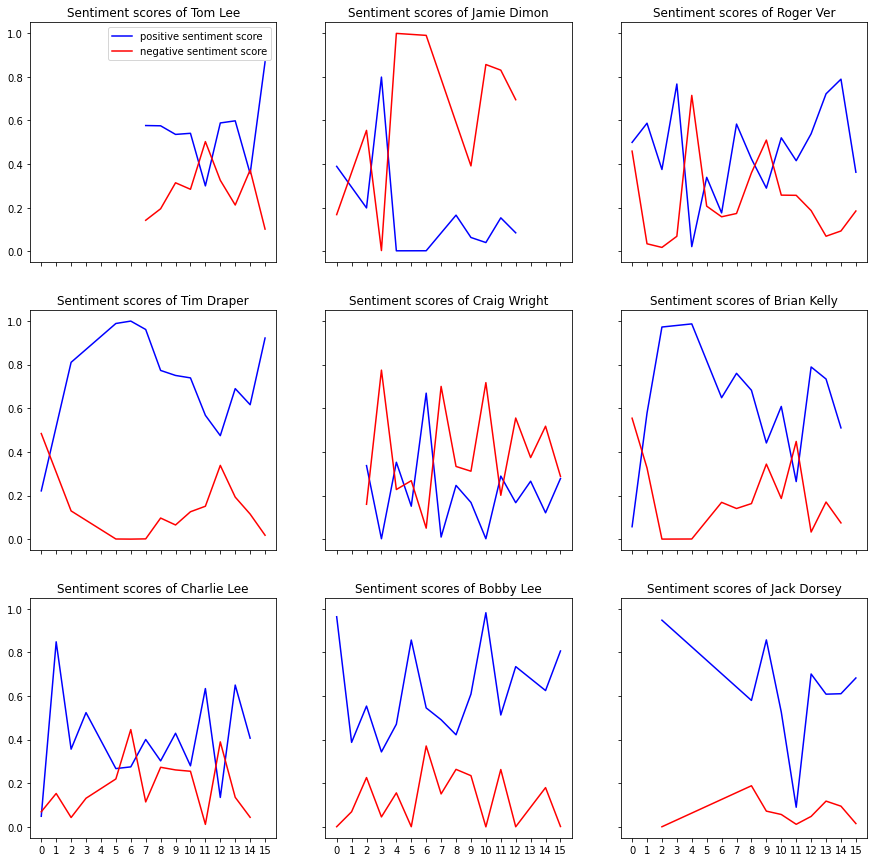

In [60]:
width, height = 3, 3
fig, ax = plt.subplots(width, height, figsize=(15,15), sharex=True, sharey=True)
ax = ax.ravel()
for i, speaker in enumerate(few_speakers):
  x = df_by_speaker_interval[df_by_speaker_interval['speaker']==speaker]['interval']
  y_pos = df_by_speaker_interval[df_by_speaker_interval['speaker']==speaker]['positive_score_btc']
  y_neg = df_by_speaker_interval[df_by_speaker_interval['speaker']==speaker]['negative_score_btc']
  ax[i].plot(x, y_pos, color='b', label='positive sentiment score')
  ax[i].plot(x, y_neg, color='r', label='negative sentiment score')
  ax[i].set_title(f'Sentiment scores of {speaker}')
ax[0].set_xticks(range(16))
ax[0].legend()

PS: the numbers from 0 to 15 correspond to 4 months period number in order from the beginning of 2015.

We can already see that by taking a few months period of time, we get better insignt on our sentiment anaylsis.<br>
All of this basic analysis will allow us to dig fruther in the desired direction in the next tasks.

## Task 2 : Occupation  Mapping <a class="anchor" id="part2.2"></a>

This task is done in the notebook "2.Occupation_mapping"

## Task 3 : Sentiment Analysis <a class="anchor" id="part2.3"></a>

This task is done in the notebook "3.Sentiment_Analysis"

## Task 4 : Causality/Correlation <a class="anchor" id="part2.4"></a>

This task is done in the notebook "4.Causality"

## Task 5 : Occupation bias <a class="anchor" id="part2.5"></a>

This task is done in the notebook "5.Occupation_Bias"